In [2]:
cd ..

/home/janek/reasonable-embeddings


In [3]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *
import random 

seed = 2022

In [4]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [5]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [6]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data[0],
    'X': data[1],
    'y': data[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col], random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()

In [8]:
rng = np.random.default_rng(seed)
T.manual_seed(seed)
random.seed(seed)
reasoner = ModifiedNeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train_mod(data_tr, data_vl, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=30, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002, identities_weight=0.2, identitity_weight_decay=0.98)

head params 3283
embs params 1430
train epoch 00/30 | batch 193/192 | loss 2.5693 | val loss 0.7433 | acc 0.0946 | f1 0.1729 | prec 0.0946 | recall 1.0000 | roc auc 0.5023 | pr auc 0.1075 | elapsed 2.09s
train epoch 01/30 | batch 193/192 | loss 1.4458 | val loss 0.2265 | acc 0.9471 | f1 0.6625 | prec 0.8346 | recall 0.5492 | roc auc 0.8764 | pr auc 0.7292 | elapsed 3.94s
train epoch 02/30 | batch 193/192 | loss 0.7378 | val loss 0.1751 | acc 0.9510 | f1 0.7312 | prec 0.7598 | recall 0.7047 | roc auc 0.9256 | pr auc 0.8075 | elapsed 3.92s
train epoch 03/30 | batch 193/192 | loss 0.5153 | val loss 0.1745 | acc 0.9426 | f1 0.7023 | prec 0.6900 | recall 0.7150 | roc auc 0.9188 | pr auc 0.7886 | elapsed 3.94s
train epoch 04/30 | batch 193/192 | loss 0.3813 | val loss 0.1800 | acc 0.9343 | f1 0.6748 | prec 0.6347 | recall 0.7202 | roc auc 0.9226 | pr auc 0.7837 | elapsed 4.35s
train epoch 05/30 | batch 193/192 | loss 0.2996 | val loss 0.1846 | acc 0.9289 | f1 0.6604 | prec 0.6026 | recall 0.

             mean  std     micro
acc      0.961293  NaN  0.961293
prec     0.756757  NaN  0.756757
recall   0.870466  NaN  0.870466
f1       0.809639  NaN  0.809639
auc_roc  0.980241  NaN  0.980241
auc_pr   0.922266  NaN  0.922266


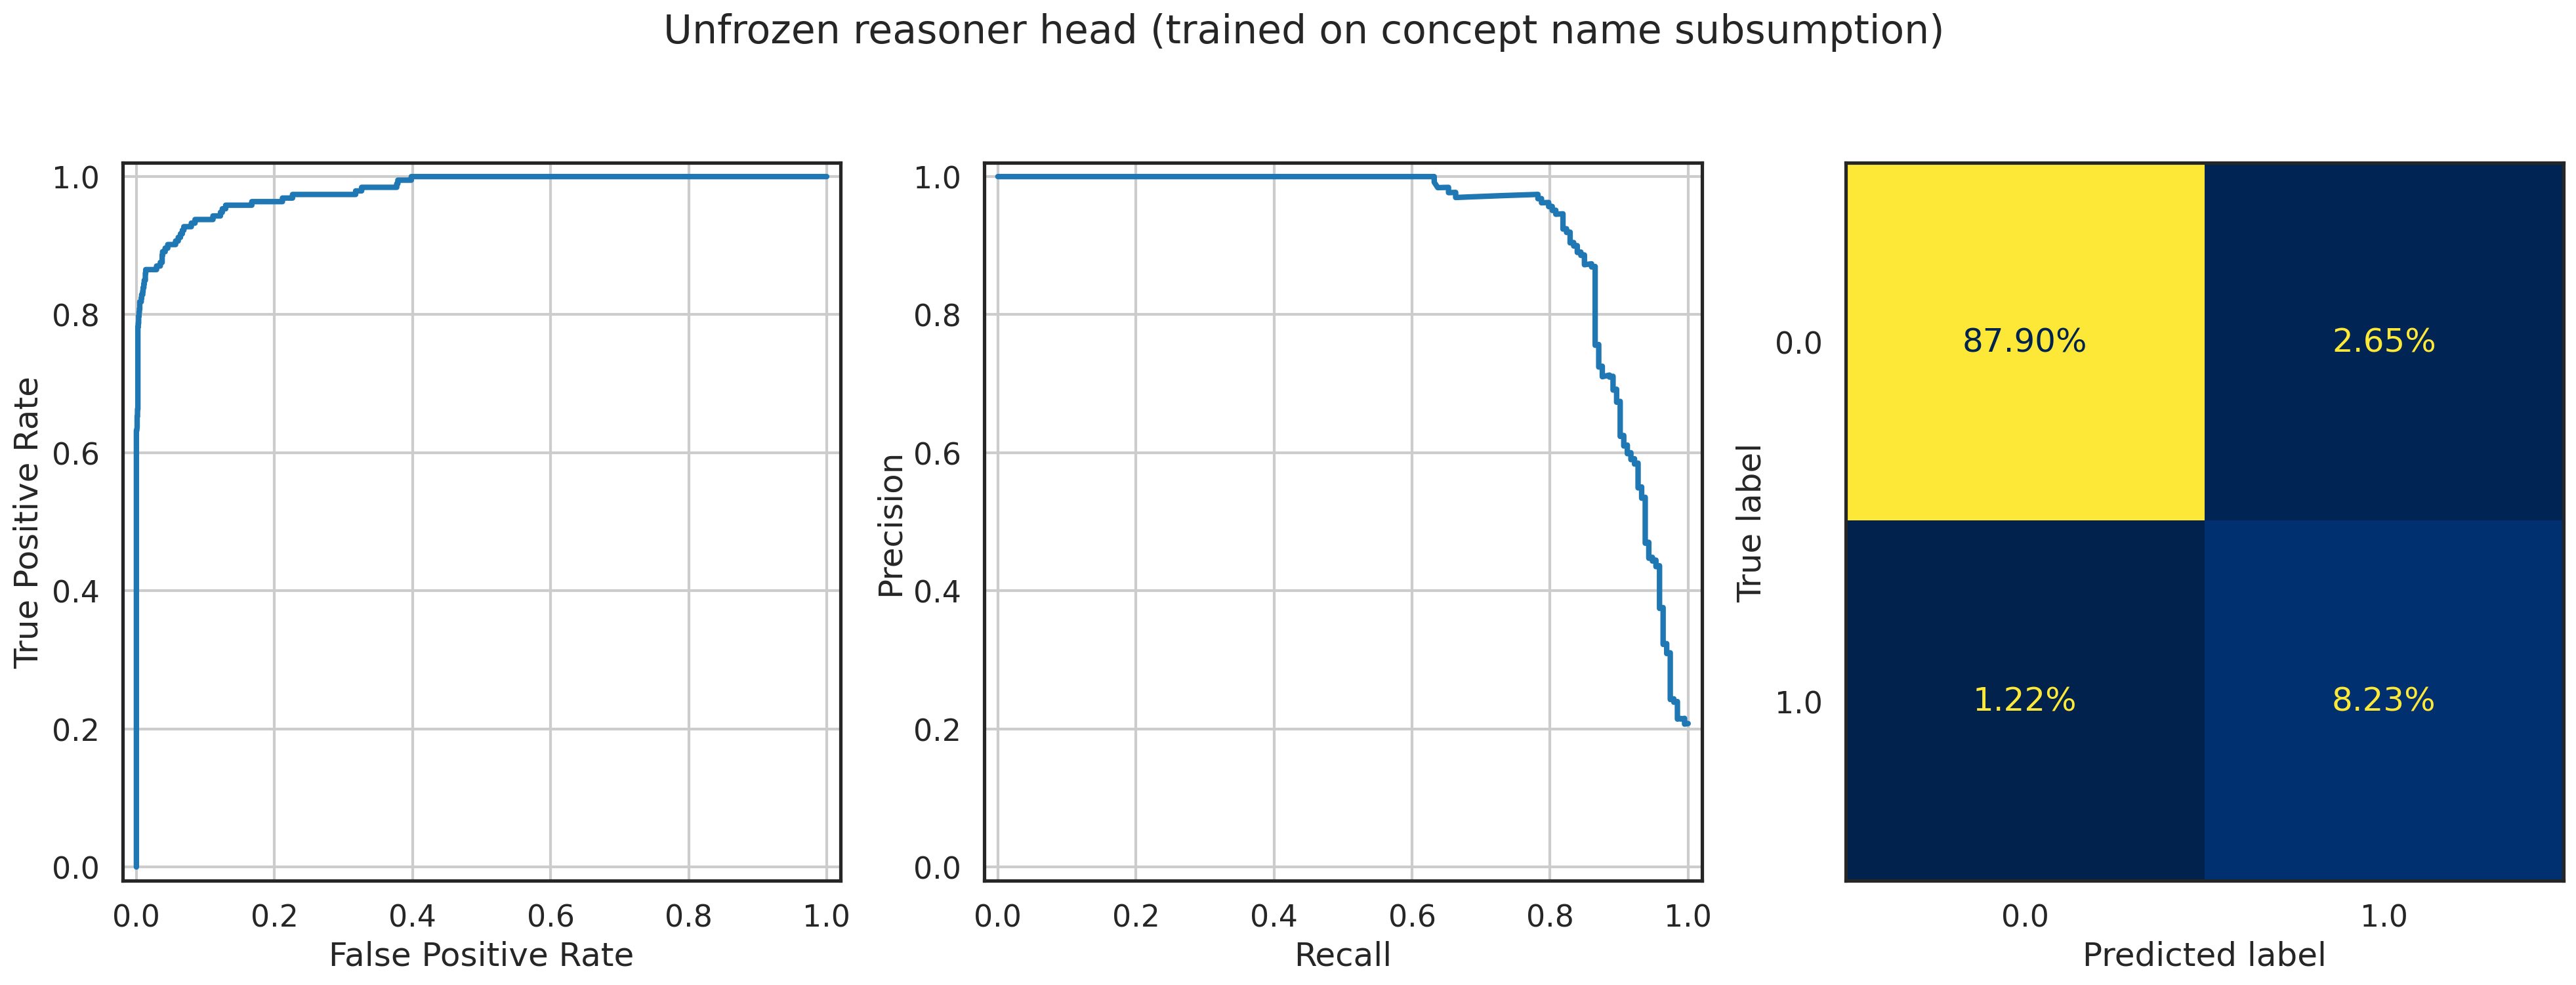

In [9]:
with T.no_grad():
    reasoner.eval()
    _, y_te, Y_te = eval_batch_mod(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_te, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

In [10]:
from random import random

In [11]:
def all_identities(reasoner, encoders, frozen):
    and_nn = reasoner.and_nn
    bot = reasoner.bot_concept
    top = reasoner.top_concept
    sub_nn =reasoner.sub_nn
    not_nn = reasoner.not_nn

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input3 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]
    loss=0
    # # A ⊓ A = A
    # loss = F.mse_loss(input1, and_nn(im_mod(input1, input1)))
    # loss += F.mse_loss(input2, and_nn(im_mod(input2, input2)))
    # loss += F.mse_loss(input3, and_nn(im_mod(input3, input3)))

    # # A ⊓ (B ⊓ C) = (A ⊓ B) ⊓ C 
    # loss += F.mse_loss(and_nn(im_mod(input1, and_nn(im_mod(input2, input3)))), and_nn(im_mod(and_nn(im_mod(input1, input2)), input3)))
    # loss += F.mse_loss(and_nn(im_mod(input2, and_nn(im_mod(input1, input3)))), and_nn(im_mod(and_nn(im_mod(input1, input2)), input3)))
    # loss += F.mse_loss(and_nn(im_mod(input3, and_nn(im_mod(input1, input2)))), and_nn(im_mod(and_nn(im_mod(input3, input2)), input1)))

    # # A ⊓ B = B ⊓ A
    # loss += F.mse_loss(and_nn(im_mod(input1, input3)), and_nn(im_mod(input3, input1)))
    # loss += F.mse_loss(and_nn(im_mod(input3, input2)), and_nn(im_mod(input2, input3)))
    # loss += F.mse_loss(and_nn(im_mod(input2, input1)), and_nn(im_mod(input1, input2)))

    # # ⊥ = A ⊓ ¬A
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input1, not_nn(input1))))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input2, not_nn(input2))))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input3, not_nn(input3))))

    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input1), input1)))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input2), input2)))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input3),input3)))

    # A = A ⊓ T
    # loss += F.mse_loss(input1, and_nn(im_mod(input1, top[0])))*2
    # loss += F.mse_loss(input1, and_nn(im_mod(input2, top[0])))*2
    # loss += F.mse_loss(input3, and_nn(im_mod(input3, top[0])))*2

    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input1)))*2
    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input2)))*2
    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input3)))*2

    # ⊥ = A ⊓ ⊥
    loss += F.mse_loss(bot[0], and_nn(im_mod(input1, bot[0])))
    loss += F.mse_loss(bot[0], and_nn(im_mod(input2, bot[0])))
    loss += F.mse_loss(bot[0], and_nn(im_mod(input3, bot[0])))

    loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input1)))
    loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input2)))
    loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input3)))

    if not frozen:
        loss += F.mse_loss(bot[0], and_nn(im_mod(top[0], bot[0])))

    #  A ⊑ T -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(input1, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input2, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input3, top[0])))).sum()
    if not frozen:
        loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], top[0])))).sum()

    #  ⊥ ⊑ A -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input1)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input2)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input3)))).sum()

    #  A ⊑ A -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(input1, input1)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input2, input2)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input3, input3)))).sum()

    #  ⊥ = ¬T  
    if not frozen:
        loss += F.l1_loss(bot[0], not_nn(top[0]))
    #  T = ¬⊥
        loss += F.l1_loss(top[0], not_nn(bot[0]))

    #  A = ¬(¬(A))
    loss += F.mse_loss(input1, not_nn(not_nn(input1)))
    loss += F.mse_loss(input2, not_nn(not_nn(input2)))
    loss += F.mse_loss(input3, not_nn(not_nn(input3)))
    if not frozen:
        loss += F.l1_loss(T.matmul(not_nn.weight, not_nn.weight), T.eye(not_nn.weight.shape[1])) * 13
    
    #  ⊥ ⊑ ⊥ -> True
    if not frozen:
        loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], bot[0])))).sum()

    return loss


all_identities(reasoner.head ,[reasoner.embs], False)

tensor(0.0060, grad_fn=<AddBackward0>)

In [12]:
from random import random

input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
print(input)
print(reasoner.head.and_nn(im_mod( input, input)))
F.l1_loss(input, reasoner.head.and_nn(im_mod(input, input)))

tensor([ 0.1987,  0.0860,  0.0947, -0.5211,  0.2837,  0.1104, -0.1062, -0.1823,
         0.7022,  0.3415], grad_fn=<SelectBackward0>)
tensor([ 0.0743, -0.1819,  0.0905,  0.0919, -0.0304, -0.0813, -0.2169,  0.1759,
         0.2610, -0.1427], grad_fn=<AddBackward0>)


tensor(0.2910, grad_fn=<L1LossBackward0>)

In [13]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
print(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)), reasoner.head.bot_concept[0]))

tensor([ 0.4686, -0.4475,  0.4427,  0.4892,  0.4506, -0.3789, -0.6323,  0.0315,
         0.6787, -0.4490], grad_fn=<SelectBackward0>)
tensor([ 0.4683, -0.4524,  0.4467,  0.4890,  0.4513, -0.3794, -0.6321,  0.0315,
         0.6792, -0.4480], grad_fn=<AddBackward0>)
tensor(0.0012, grad_fn=<L1LossBackward0>)


In [14]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)), input))


tensor([0.3273, 0.5818, 0.0194, 0.8494, 0.3162, 0.6748, 0.4223, 0.4084, 0.2705,
        0.1507])
tensor([-0.0429, -0.1902,  0.0886, -0.0529, -0.2352,  0.3252, -0.0261,  0.1429,
        -0.1000,  0.3235], grad_fn=<AddBackward0>)
tensor(0.4272, grad_fn=<L1LossBackward0>)


In [15]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
output = reasoner.head.and_nn(im_mod(reasoner.head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.4686, -0.4475,  0.4427,  0.4892,  0.4506, -0.3789, -0.6323,  0.0315,
         0.6787, -0.4490], grad_fn=<SelectBackward0>)
tensor([-0.0574, -0.0091,  0.0792, -0.1660,  0.1338, -0.1517, -0.0246,  0.1363,
        -0.0882, -0.0873], grad_fn=<AddBackward0>)
tensor(0.2432, grad_fn=<L1LossBackward0>)


In [16]:
print(reasoner.head.bot_concept[0])
output = reasoner.head.not_nn(reasoner.head.top_concept[0])
print(output)
print(F.mse_loss(reasoner.head.bot_concept[0], output))

tensor([ 0.4686, -0.4475,  0.4427,  0.4892,  0.4506, -0.3789, -0.6323,  0.0315,
         0.6787, -0.4490], grad_fn=<SelectBackward0>)
tensor([ 0.4687, -0.4473,  0.4427,  0.4898,  0.4506, -0.3783, -0.6325,  0.0327,
         0.6789, -0.4475], grad_fn=<SqueezeBackward3>)
tensor(4.3028e-07, grad_fn=<MseLossBackward0>)


In [17]:
print(reasoner.head.top_concept[0])
output = reasoner.head.not_nn(reasoner.head.bot_concept[0])
print(output)
print(F.mse_loss(reasoner.head.top_concept[0], output))

tensor([-0.4332, -0.1319,  0.2561, -0.1174,  0.3653,  0.3118,  0.6381,  0.1263,
        -1.0239,  0.6526], grad_fn=<SelectBackward0>)
tensor([-0.4333, -0.1323,  0.2571, -0.1184,  0.3649,  0.3116,  0.6393,  0.1263,
        -1.0238,  0.6525], grad_fn=<SqueezeBackward3>)
tensor(3.6639e-07, grad_fn=<MseLossBackward0>)


In [18]:
input1 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
input2 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.and_nn(im_mod(input2,input1)))
print(reasoner.head.and_nn(im_mod(input1,input2)))

F.mse_loss(reasoner.head.and_nn(im_mod(input2,input1)) , reasoner.head.and_nn(im_mod(input1,input2)))

tensor([ 0.1200, -0.1012,  0.1200, -0.0666,  0.0290, -0.0373, -0.1201,  0.0231,
         0.1023, -0.1337], grad_fn=<AddBackward0>)


tensor([ 0.0561,  0.0280,  0.1016, -0.0514,  0.1284,  0.0216, -0.0354,  0.0619,
        -0.0778, -0.0188], grad_fn=<AddBackward0>)


tensor(0.0089, grad_fn=<MseLossBackward0>)

In [19]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.3

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te_2))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te_2[błędne_predykcje],
    'Predykcja': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

print(wyniki)

    Rekord  Prawdziwa Etykieta     Predykcja  Feature_0  Feature_1  Feature_2
0        2                 1.0  1.451622e-04          0         77         41
1        4                 1.0  9.596165e-08          0          7          7
2        7                 0.0  9.801056e-01          0          4         90
3       13                 0.0  9.756719e-01          0         70         59
4       18                 1.0  2.515203e-02          0         98         96
..     ...                 ...           ...        ...        ...        ...
82    1840                 0.0  7.116930e-01          0         46         68
83    1860                 0.0  9.979596e-01          0         91         80
84    1938                 0.0  4.072368e-01          0         94         96
85    1985                 1.0  2.447691e-01          0         27         97
86    2008                 0.0  9.234418e-01          0         84         28

[87 rows x 6 columns]


In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wyniki)

    Rekord  Prawdziwa Etykieta     Predykcja  Feature_0  Feature_1  Feature_2
0        2                 1.0  1.451622e-04          0         77         41
1        4                 1.0  9.596165e-08          0          7          7
2        7                 0.0  9.801056e-01          0          4         90
3       13                 0.0  9.756719e-01          0         70         59
4       18                 1.0  2.515203e-02          0         98         96
5       55                 0.0  9.706314e-01          0         54         48
6       60                 0.0  8.870392e-01          0         66         90
7       89                 1.0  1.884013e-04          0         29         40
8      116                 1.0  3.071444e-02          0         17         48
9      124                 0.0  8.152800e-01          0          3         10
10     133                 1.0  2.547802e-03          0          1         41
11     144                 0.0  5.580945e-01          0         

In [21]:

print(T.round( T.matmul( reasoner.head.not_nn.weight,reasoner.head.not_nn.weight) *100)/100)

tensor([[1., 0., 0., 0., -0., -0., 0., 0., -0., 0.],
        [0., 1., -0., -0., 0., -0., 0., 0., 0., -0.],
        [0., -0., 1., 0., 0., 0., -0., -0., -0., 0.],
        [0., -0., 0., 1., 0., -0., -0., -0., 0., -0.],
        [0., 0., 0., 0., 1., 0., -0., -0., -0., 0.],
        [-0., -0., -0., -0., -0., 1., 0., 0., -0., -0.],
        [0., -0., 0., -0., -0., 0., 1., -0., -0., 0.],
        [0., -0., 0., 0., 0., 0., -0., 1., 0., 0.],
        [0., -0., -0., 0., -0., -0., -0., 0., 1., -0.],
        [-0., 0., 0., -0., 0., -0., -0., -0., 0., 1.]], grad_fn=<DivBackward0>)
